<a href="https://colab.research.google.com/github/adsamaz/Chattbot/blob/master/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data



In [0]:
# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("https://raw.githubusercontent.com/adsamaz/Chattbot/master/ANN_project_files/amazon_cells_labelled.txt?token=AH6YBL7A3NJ4RA5LTSEYWC254TOFO", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )
    print(training_data.shape)

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


HTTPError: ignored

(900, 7305)


In [0]:
# This code initializes the neural network
network = nn.Sequential(
    nn.Linear(7305, 500), nn.ReLU(), nn.Linear(500, 2)
)

# Initialize the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.01)

# Initialize the loss function
loss_function = nn.MSELoss()

# An Embedding layer used for turning int into one-hot (0 -> [1,0,0,0,0,0,0,0,0,0], 5 -> [0,0,0,0,0,1,0,0,0,0])
to_onehot = nn.Embedding(2, 2) 
to_onehot.weight.data = torch.eye(2)

to_onehot(train_y_tensor)

NameError: ignored

Epoch 30 - Loss: 0.002951135626062751

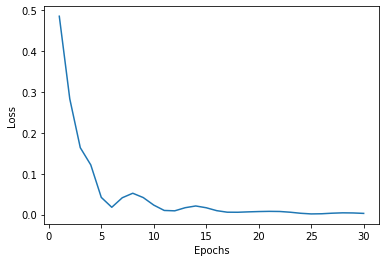

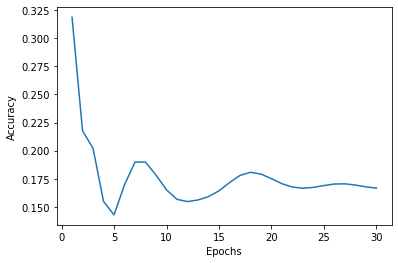

In [0]:
# Decide the number of epochs to train for (one epoch is one complete run-through of the data)
epochs = 30


# Create a list to keep track of how the loss changes
losses = []
validation_epoch_losses = []
accuracy = [0]
# For each epoch
for epoch in range(epochs):

    # A variable for containing the sum of all batch losses for this epoch
    epoch_loss = 0
    validation_epoch_loss = 0

    # For each batch
    #for batch_nr, (images, labels) in enumerate(train_loader):

    # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
    labels = to_onehot(train_y_tensor)

    # Predict for each digit in the batch whatclass they belong to
    prediction = network(train_x_tensor)

    # Calculate the loss of the prediction by comparing to the expected output
    loss = loss_function(prediction, labels)

    # Backpropogate the loss through the network to find the gradients of all parameters
    loss.backward()

    # Update the parameters along their gradients
    optimizer.step()

    # Clear stored gradient values
    optimizer.zero_grad()

    # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
    epoch_loss += loss.item()

    # Print the epoch, batch, and loss
    print(
        '\rEpoch {} - Loss: {}'.format(
            epoch+1, loss
        ),
        end=''
    )

    # Append the epoch loss to the list of losses
    #accu = validate_on_images(iter(validation_loader))
    #accuracy.append(accu)
    #print(" Accuracy:",accu)
    losses.append(epoch_loss)

  

    #Check on validation

    # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
    labels = to_onehot(validation_y_tensor)

    # Predict for each digit in the batch whatclass they belong to
    prediction = network(validation_x_tensor)
    
    # Calculate the loss of the prediction by comparing to the expected output
    loss = loss_function(prediction, labels)
      
      
      
    validation_epoch_loss += loss.item()
    validation_epoch_losses.append(validation_epoch_loss)   


# Plot the training loss per epoch
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(range(1, epochs+1), validation_epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Have the trained network predict on some images
#predict_on_images(iterator=iter(train_loader), images_to_show=10)

In [6]:
#print(train_x_tensor.shape)

#scent = "I like this"
scent = np.array(["good"])
data = word_vectorizer.transform(scent).todense()

data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)

prediction = network(data)

print(prediction)

if prediction[0][0] > prediction[0][1]:
  print("BAD")
else:
  print("GOOD")

NameError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/My Drive/Chatbot_shared/reviews_Video_Games_5.json.gz')



In [0]:
test=df

In [47]:
test=df
test=test.get(['reviewText','overall'])
test=test[test.overall != 3.0] 
test=test.replace(1.0, 0)
test=test.replace(2.0, 0)
test=test.replace(4.0, 1)
test=test.replace(5.0, 1)
reviews = test.reviewText
labels = test.overall
test


,reviewText,overall
0,Installing the game was a struggle (because of...,0.0
1,If you like rally cars get this game you will ...,1.0
2,1st shipment received a book instead of the ga...,0.0
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,1.0
5,"Overall this is a well done racing game, with ...",1.0
...,...,...
231775,Funny people on here are rating sellers that a...,1.0
231776,All this is is the Deluxe 32GB Wii U with Mari...,0.0
231777,The package should have more red on it and sho...,0.0
231778,Can get this at Newegg for $329.00 and the pac...,0.0


In [54]:
#Removes symbols and lowercases
reviews = reviews.str.lower()
reviews = reviews.str.replace(r'[^\w\s]+','')

0         installing the game was a struggle because of ...
1         if you like rally cars get this game you will ...
2         1st shipment received a book instead of the ga...
4         i had dirt 2 on xbox 360 and it was an okay ga...
5         overall this is a well done racing game with v...
                                ...                        
231775    funny people on here are rating sellers that a...
231776    all this is is the deluxe 32gb wii u with mari...
231777    the package should have more red on it and sho...
231778    can get this at newegg for 32900 and the packa...
231779    this is not real you can go to any retail stor...
Name: reviewText, Length: 203505, dtype: object

In [63]:
from collections import Counter
#Tokenizer
all_text = ' '.join(reviews)
words = all_text.split()

#Count all the words
count_words = Counter(words)

# Sort words after which is most common
total_words = len(words)
sorted_words = count_words.most_common(total_words)
sorted_words

[('the', 2207986),
 ('and', 1148395),
 ('to', 1070778),
 ('a', 1023248),
 ('of', 815022),
 ('is', 739859),
 ('you', 719567),
 ('i', 711698),
 ('game', 647030),
 ('it', 622707),
 ('this', 527217),
 ('in', 487963),
 ('that', 436955),
 ('for', 395305),
 ('are', 330321),
 ('with', 312144),
 ('but', 307965),
 ('on', 278908),
 ('have', 278001),
 ('as', 264403),
 ('not', 213547),
 ('its', 198503),
 ('was', 197680),
 ('can', 196590),
 ('be', 193208),
 ('your', 187043),
 ('like', 185932),
 ('if', 175798),
 ('games', 172781),
 ('all', 169204),
 ('or', 169094),
 ('so', 168962),
 ('one', 161936),
 ('my', 160045),
 ('just', 149790),
 ('get', 142303),
 ('more', 141091),
 ('at', 137089),
 ('there', 134196),
 ('from', 132939),
 ('they', 132859),
 ('play', 132827),
 ('will', 129378),
 ('out', 120430),
 ('up', 117387),
 ('some', 116548),
 ('has', 113866),
 ('an', 113653),
 ('very', 110153),
 ('great', 106313),
 ('really', 104958),
 ('good', 104096),
 ('when', 101733),
 ('time', 100093),
 ('fun', 98337),

In [64]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
vocab_to_int

{'the': 1,
 'and': 2,
 'to': 3,
 'a': 4,
 'of': 5,
 'is': 6,
 'you': 7,
 'i': 8,
 'game': 9,
 'it': 10,
 'this': 11,
 'in': 12,
 'that': 13,
 'for': 14,
 'are': 15,
 'with': 16,
 'but': 17,
 'on': 18,
 'have': 19,
 'as': 20,
 'not': 21,
 'its': 22,
 'was': 23,
 'can': 24,
 'be': 25,
 'your': 26,
 'like': 27,
 'if': 28,
 'games': 29,
 'all': 30,
 'or': 31,
 'so': 32,
 'one': 33,
 'my': 34,
 'just': 35,
 'get': 36,
 'more': 37,
 'at': 38,
 'there': 39,
 'from': 40,
 'they': 41,
 'play': 42,
 'will': 43,
 'out': 44,
 'up': 45,
 'some': 46,
 'has': 47,
 'an': 48,
 'very': 49,
 'great': 50,
 'really': 51,
 'good': 52,
 'when': 53,
 'time': 54,
 'fun': 55,
 'about': 56,
 'which': 57,
 'only': 58,
 'me': 59,
 'do': 60,
 'much': 61,
 'also': 62,
 'other': 63,
 'no': 64,
 'even': 65,
 'what': 66,
 'than': 67,
 'first': 68,
 'dont': 69,
 'by': 70,
 'would': 71,
 'well': 72,
 'them': 73,
 'new': 74,
 'had': 75,
 'because': 76,
 'graphics': 77,
 'story': 78,
 'playing': 79,
 'into': 80,
 'still': 

In [97]:
reviews_int = []
for review in reviews:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print (reviews_int[0:3])


[[3041, 1, 9, 23, 4, 3845, 76, 5, 29, 14, 1067, 451, 67590, 5151, 1043, 2, 478, 24, 58, 25, 1433, 70, 418, 73, 20, 48, 3116, 3, 1, 9, 8, 1213, 766, 695, 1258, 53, 1, 9, 23, 74, 8, 69, 27, 1, 549, 13, 8, 19, 3, 217, 1674, 3, 217, 13201, 1118, 64, 1097, 12, 1, 1365, 31, 77, 647, 3, 2692, 9862, 6142, 10, 12, 1, 2182, 2, 24004, 146, 3, 114, 189, 7984, 9, 103, 51, 1244, 5, 640, 390, 161117, 29, 161118, 973, 3, 36, 34, 1089, 40, 11595, 9574, 4449, 2, 7, 162, 3, 161119, 7, 14, 866, 34, 291, 28, 7, 412, 10, 25, 235, 3, 930, 10, 20, 1640], [28, 7, 27, 4449, 478, 36, 11, 9, 7, 43, 19, 14669, 6, 37, 3986, 3, 161120, 59121, 151, 194, 12, 2696, 39, 208, 4, 318, 4449, 226, 559, 211, 10, 6, 49, 4871, 2, 65, 1, 1452, 40, 1, 9, 49, 161121, 80805, 229, 208, 1, 90, 17, 10, 289, 35, 652], [1392, 10924, 1309, 4, 981, 301, 5, 1, 104091, 10924, 129, 4, 3725, 33, 9, 1969, 16, 4, 480, 915, 1070, 18, 6176, 604, 8, 129, 12, 3164, 16, 7984, 2, 1496, 73, 1978, 5, 1, 1457, 2, 1, 561, 41, 288, 257, 41, 24, 60, 22, 4

In [98]:
encoded_labels = np.array(labels)
encoded_labels

array([0., 1., 0., ..., 0., 0., 0.])

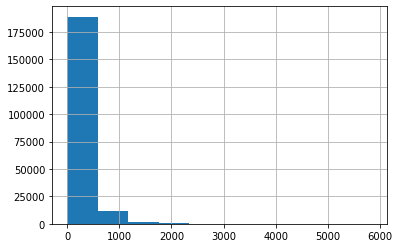

count    203505.000000
mean        197.909757
std         271.210808
min           0.000000
25%          43.000000
50%         102.000000
75%         239.000000
max        5842.000000
dtype: float64

In [99]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [0]:
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

In [0]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review        
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features


In [102]:
features = np.array(pad_features(reviews_int,200))
features

array([[   0,    0,    0, ...,   10,   20, 1640],
       [   0,    0,    0, ...,  289,   35,  652],
       [   0,    0,    0, ...,   10,   52, 8039],
       ...,
       [   0,    0,    0, ...,  495, 4964,  137],
       [   0,    0,    0, ...,  604,   23,  638],
       [   0,    0,    0, ...,   35,   25, 2929]])

In [103]:
# SPlitting data into training, validation and testing
split_frac = 0.6
len_feat=len(features)
encoded_labels = np.array(encoded_labels)

train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]


type(train_y)

numpy.ndarray

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [106]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) 
# batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 
# batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   33,     5,     1,  ...,    60,  2065,   256],
        [    0,     0,     0,  ...,    81,    12,    10],
        [    0,     0,     0,  ...,  6277,   144,   147],
        ...,
        [    0,     0,     0,  ...,  2155,     3,    97],
        [    0,     0,     0,  ...,    96,    30,  3641],
        [    0,     0,     0,  ...,   162,    25, 55227]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       dtype=torch.float64)
